In [19]:
import pandas as pd
import numpy as np
import re
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import ast
from scipy.stats import mstats
from sklearn.ensemble import RandomForestRegressor

# Ignore warnings
warnings.filterwarnings("ignore")

# Function to clean input values
def clean_value(value):
    if pd.isna(value):
        return None
    elif isinstance(value, str):
        return value.strip()
    return value

# Function to safely convert string representations of dictionaries
def str_to_dict(value):
    if isinstance(value, dict):
        return value
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return {}
    return {}

# Function to clean kilometers driven values
def clean_kms_driven(value):
    if isinstance(value, str):
        return int(re.sub(r'\D', '', value))
    return value

# Function to clean price values
def clean_price(value):
    if isinstance(value, str):
        value = value.replace('₹', '').replace(',', '').strip()
        if 'Crore' in value:
            value = value.replace('Crore', '').strip()
            return float(value) * 10000000
        elif 'Lakh' in value:
            value = value.replace('Lakh', '').strip()
            return float(value) * 100000
        return float(value)
    if value:
        return value
    return None

# Function to clean registration year values
def clean_registration_year(value):
    if isinstance(value, str):
        return re.sub(r'\b[A-Za-z]{3,9}\s+', '', value)
    return value

# Function to clean other attributes
def clean_attribute(value, suffix):
    return re.sub(fr'\s*{suffix}', '', value) if isinstance(value, str) else value

# 1a. Import and concatenate datasets
file_paths = [
    'bangalore_cars.xlsx',
    'chennai_cars.xlsx',
    'delhi_cars.xlsx',
    'hyderabad_cars.xlsx',
    'jaipur_cars.xlsx',
    'kolkata_cars.xlsx'
]
dfs = []
for file_path in file_paths:
    df = pd.read_excel(file_path)
    location = file_path.split('_')[0].capitalize()
    df['City'] = location
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True)

# 1b. Process each row in the combined DataFrame
processed_rows = []

for index, row in combined_df.iterrows():
    new_car_detail = str_to_dict(row['new_car_detail'])
    flat_entry = {
        'Fuel Type': new_car_detail.get('ft'),
        'Body Type': new_car_detail.get('bt'),
        'Kms Driven': clean_kms_driven(new_car_detail.get('km')),
        'Transmission': new_car_detail.get('transmission'),
        'Owner': clean_value(new_car_detail.get('ownerNo')),
        'Owner Details': new_car_detail.get('owner'),
        'OEM': new_car_detail.get('oem'),
        'Model': new_car_detail.get('model'),
        'Model Year': clean_value(new_car_detail.get('modelYear')),
        'Variant Name': new_car_detail.get('variantName'),
        'Price': clean_price(new_car_detail.get('price')),
        'City': clean_value(row['City']),
        'Car Link': row.get('car_links')
    }
    
    if 'new_car_overview' in row:
        new_car_overview = str_to_dict(row['new_car_overview'])
        for item in new_car_overview.get('top', []):
            key = item.get('key')
            value = item.get('value')
            if key == 'Registration Year':
                flat_entry['Registration Year'] = clean_registration_year(value)
            elif key == 'Insurance Validity':
                flat_entry['Insurance Validity'] = value
            elif key == 'Seats':
                flat_entry['Seats'] = clean_attribute(value, 'Seats')
            elif key == 'Engine Displacement':
                flat_entry['Engine Displacement'] = clean_attribute(value, 'cc')
                
    if 'new_car_feature' in row:
        new_car_feature = str_to_dict(row['new_car_feature'])
        for feature in new_car_feature.get('top', []):
            value = feature.get('value')
            if value:
                flat_entry.setdefault('Entertainment', []).append(value)
        for category in new_car_feature.get('data', []):
            heading = category.get('heading', '')
            items = category.get('list', [])
            for item in items:
                value = item.get('value', '')
                if value:
                    flat_entry.setdefault(heading, []).append(value)

    processed_rows.append(flat_entry)

    if 'new_car_specs' in row:
        new_car_specs = str_to_dict(row['new_car_specs'])
        for spec in new_car_specs.get('top', []):
            key = spec.get('key')
            value = spec.get('value')
            if key == 'Mileage':
                flat_entry['Mileage'] = clean_attribute(value, 'kmpl')
            elif key == 'Max Power':
                flat_entry['Max Power'] = clean_attribute(value, 'bhp')
            elif key == 'Torque':
                flat_entry['Torque'] = clean_attribute(value, 'Nm')
            elif key == 'Wheel Size':
                flat_entry['Wheel Size'] = clean_value(value)
            elif key == 'Seats':
                flat_entry['Seating Capacity'] = clean_value(value)

# 1c. Create a DataFrame from the processed rows
processed_df = pd.DataFrame(processed_rows)

# 1d. Handling Missing Values
categorical_cols = [
    'Fuel Type', 'Body Type', 'Transmission', 'Owner Details', 'OEM', 'Model', 
    'Variant Name', 'City', 'Insurance Validity', 'Seats', 
    'Comfort & Convenience', 'Interior', 'Exterior', 'Safety', 
    'Entertainment', 'Car Link', 'Engine Displacement', 'Model Year', 'Seating Capacity'
]

# Fill categorical columns with the mode
for col in categorical_cols:
    if processed_df[col].isnull().any():
        mode_value = processed_df[col].mode()[0]
        if isinstance(mode_value, list):
            mode_value = mode_value[0]  
        processed_df[col] = processed_df[col].fillna(mode_value)

numerical_cols = [
    'Kms Driven', 'Price', 'Mileage', 'Max Power', 'Torque', 'Wheel Size', 'Owner'
]

# Fill numerical columns with the median
for col in numerical_cols:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
    if processed_df[col].isnull().any():
        median_value = processed_df[col].median()
        if isinstance(median_value, list):
            median_value = median_value[0]  
        processed_df[col] = processed_df[col].fillna(median_value)

# 1e. Standardizing Data Formats
float_columns = ['Mileage', 'Max Power', 'Torque']
for col in float_columns:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce').fillna(0.0)

int_columns = [
    'Kms Driven', 'Price', 'Mileage', 'Max Power', 'Torque', 'Wheel Size', 'Owner'
]
for col in int_columns:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce').fillna(0).astype(int)        


# Feature Engineering
current_year = datetime.now().year
processed_df['Age of Car'] = current_year - processed_df['Model Year']

# Set the limit for top N unique values
columns_to_drop = [
    'Variant Name', 
    'Car Link',
    'Owner Details',
    'Comfort & Convenience', 
    'Interior', 
    'Exterior', 
    'Entertainment & Communication',
    'Entertainment',
    'Safety', 'Registration Year', 'Seating Capacity'
]

# Step 2: Drop the specified categorical columns
df_dropped = processed_df.drop(columns=columns_to_drop, errors='ignore')

def map_insurance_validity(value):
    if value == 'Third Party insurance':
        return 1
    elif value == 'Comprehensive':
        return 2
    elif value == 'Third Party':
        return 3
    elif value == 'Zero Dep':
        return 4
    elif value in ['1', '2', 'Not Available', '']:  
        return 0  
    else:
        return -1  

df_dropped['Insurance Validity'] = df_dropped['Insurance Validity'].apply(map_insurance_validity)

# Proceed with One-Hot Encoding
columns_to_encode = ['Fuel Type', 'Body Type', 'Transmission', 'OEM', 'Model', 'City']
for col in columns_to_encode:
    if col not in df_dropped.columns:
        df_dropped[col] = 'Unknown'  

# 2. Apply one-hot encoding after ensuring all columns are present
df_encoded = pd.get_dummies(df_dropped, columns=columns_to_encode, drop_first=True)

# 3. Convert boolean columns to integers (0/1)
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)


# Now, you can directly use df_encoded
from sklearn.preprocessing import OrdinalEncoder
df_cleaned = df_encoded.copy()
ordinal_encoder = OrdinalEncoder()
df_cleaned['Seats_ordinal'] = ordinal_encoder.fit_transform(df_cleaned[['Seats']])
df_cleaned['Model_Year_ordinal'] = ordinal_encoder.fit_transform(df_cleaned[['Model Year']])
df_cleaned['Engine_Displacement_ordinal'] = ordinal_encoder.fit_transform(df_cleaned[['Engine Displacement']])

# Remove outliers using the Z-score method across multiple columns
def remove_outliers_z_score(df, columns, threshold=3):
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=columns)
    z_scores = np.abs(stats.zscore(df_clean[columns]))
    return df_clean[(z_scores < threshold).all(axis=1)]

# Numerical columns for outlier removal
numerical_columns = ['Price', 'Mileage', 'Kms Driven'] 

# Apply Z-score based outlier removal
df_cleaned = remove_outliers_z_score(df_cleaned, numerical_columns)

# Check the final data shape
print(f"Data shape after outlier removal: {df_cleaned.shape}")

# Save the processed DataFrame to a CSV file with versioning
output_file = 'df_cleaned_car_details.csv'
base_name, ext = os.path.splitext(output_file)
version = 1
while os.path.exists(output_file):
    output_file = f"{base_name}_v{version}{ext}"
    version += 1

df_cleaned.to_csv(output_file, index=False)
print(f"Data has been processed and saved as {output_file}.")

output_file = 'combined_car_details.csv'
base_name, ext = os.path.splitext(output_file)
version = 1
while os.path.exists(output_file):
    output_file = f"{base_name}_v{version}{ext}"
    version += 1
processed_df.to_csv(output_file, index=False)
print(f"Data has been processed and saved as {output_file}.")


Data shape after outlier removal: (8178, 381)
Data has been processed and saved as df_cleaned_car_details_v1.csv.
Data has been processed and saved as combined_car_details_v2.csv.


In [20]:
df_cleaned

,Kms Driven,Owner,Model Year,Price,Insurance Validity,Seats,Engine Displacement,Mileage,Max Power,Torque,...,Model_Volvo XC40,Model_Volvo XC60,City_Chennai,City_Delhi,City_Hyderabad,City_Jaipur,City_Kolkata,Seats_ordinal,Model_Year_ordinal,Engine_Displacement_ordinal
0,120000,3,2015,400000,1,5,998,23,67,90,...,0,0,0,0,0,0,0,3.0,20.0,148.0
1,32706,2,2018,811000,2,5,1497,17,121,150,...,0,0,0,0,0,0,0,3.0,23.0,44.0
2,11949,1,2018,585000,2,5,1199,23,84,114,...,0,0,0,0,0,0,0,3.0,23.0,14.0
3,17794,1,2014,462000,2,5,1197,19,81,113,...,0,0,0,0,0,0,0,3.0,19.0,12.0
4,60000,1,2015,790000,1,5,1248,23,88,200,...,0,0,0,0,0,0,0,3.0,20.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,10000,1,2022,509999,1,5,998,25,65,89,...,0,0,0,0,0,0,1,3.0,27.0,148.0
8365,120000,1,2014,180000,1,5,796,22,47,69,...,0,0,0,0,0,0,1,3.0,19.0,141.0
8366,50000,3,2011,550000,1,5,1796,11,186,285,...,0,0,0,0,0,0,1,3.0,16.0,59.0
8367,40000,1,2012,140000,1,5,1197,18,85,114,...,0,0,0,0,0,0,1,3.0,17.0,12.0


Descriptive Statistics:
           Kms Driven        Owner   Model Year         Price  \
count     8178.000000  8178.000000  8178.000000  8.178000e+03   
unique            NaN          NaN          NaN           NaN   
top               NaN          NaN          NaN           NaN   
freq              NaN          NaN          NaN           NaN   
mean     58386.548056     1.364637  2016.426755  8.242310e+05   
std      34224.157981     0.645267     3.916029  7.679335e+05   
min          0.000000     0.000000  1985.000000  2.016100e+04   
25%      31000.000000     1.000000  2014.000000  3.950000e+05   
50%      54419.500000     1.000000  2017.000000  6.000000e+05   
75%      80000.000000     2.000000  2019.000000  9.192492e+05   
max     260000.000000     5.000000  2023.000000  5.200000e+06   

        Insurance Validity Seats Engine Displacement      Mileage  \
count          8178.000000  8178                8178  8178.000000   
unique                 NaN     8                 134     

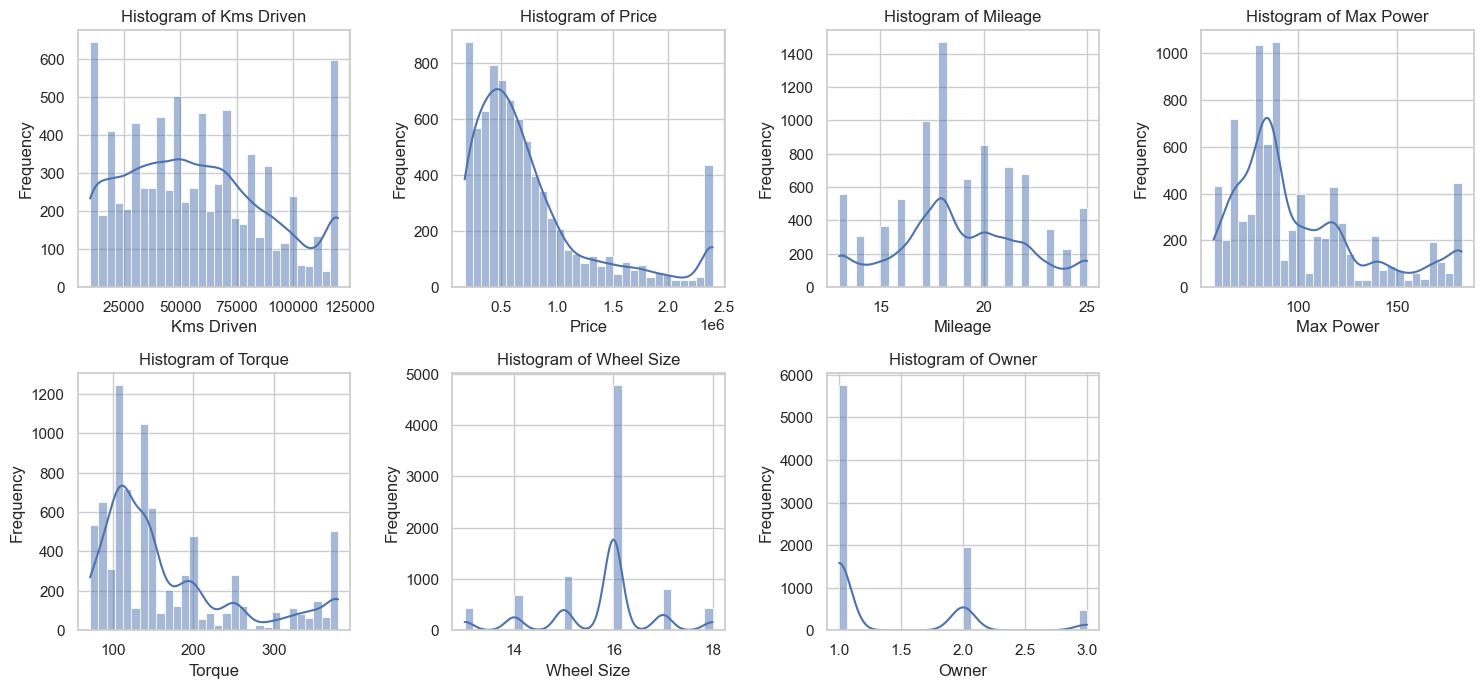

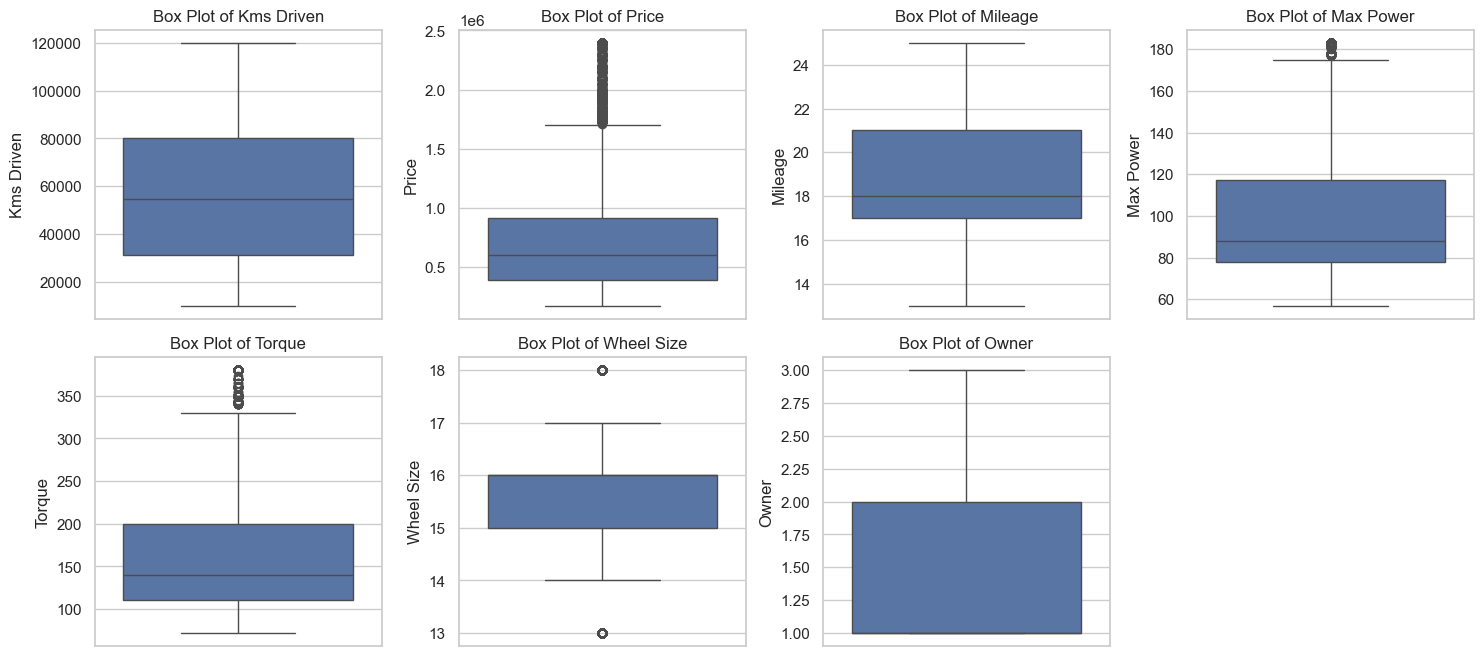

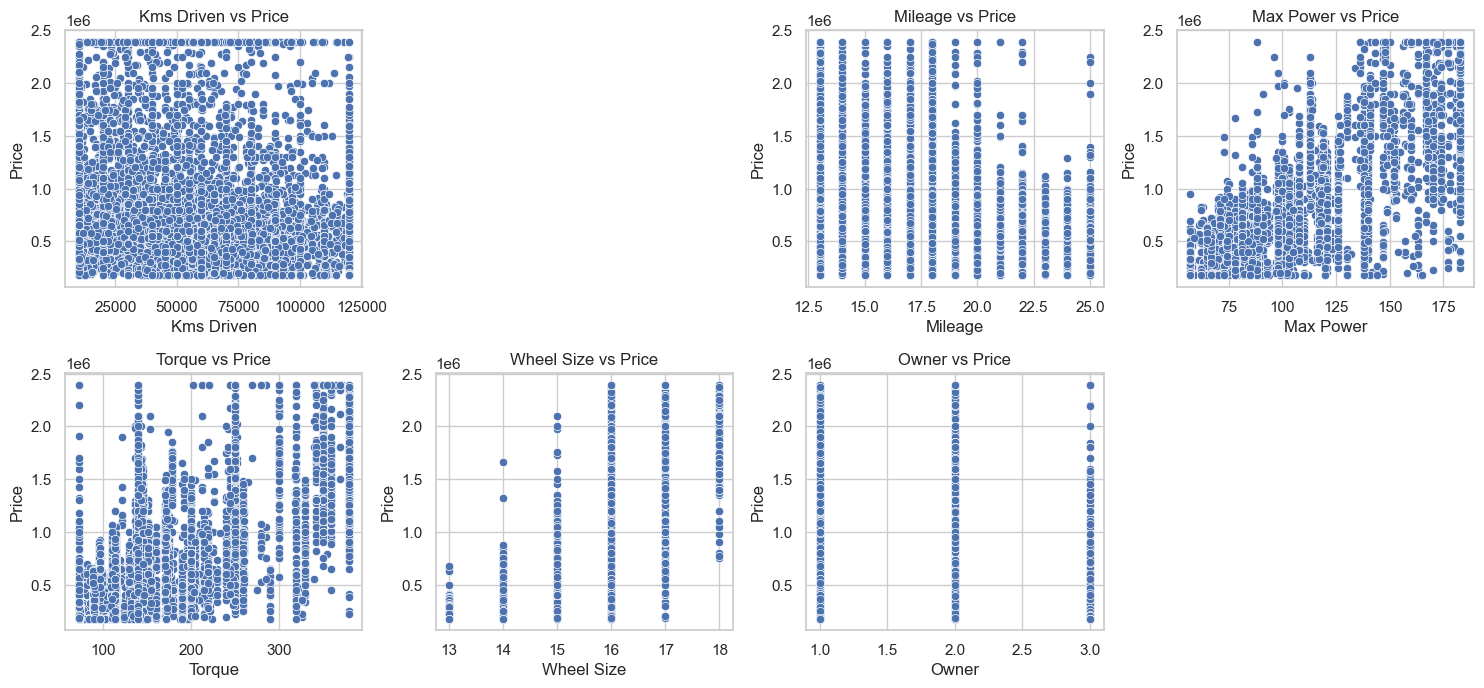

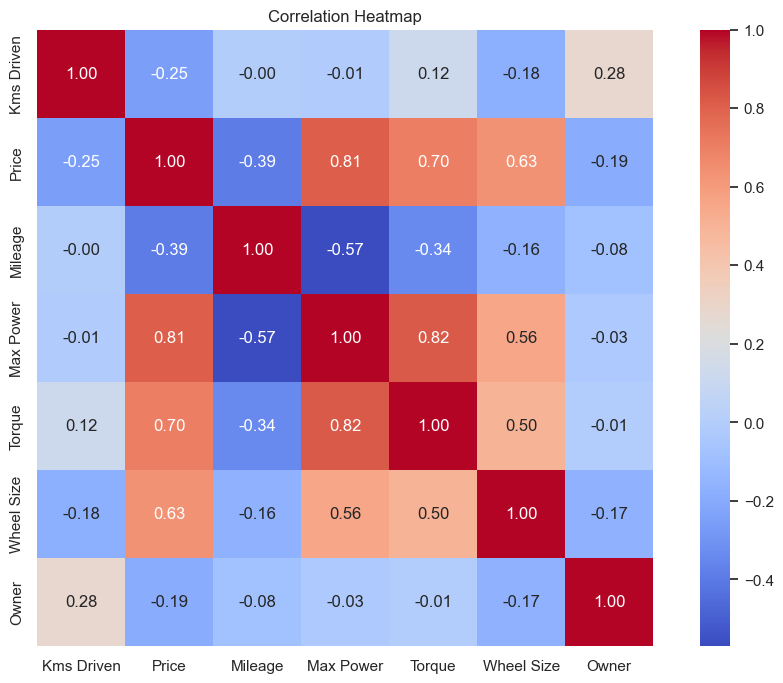

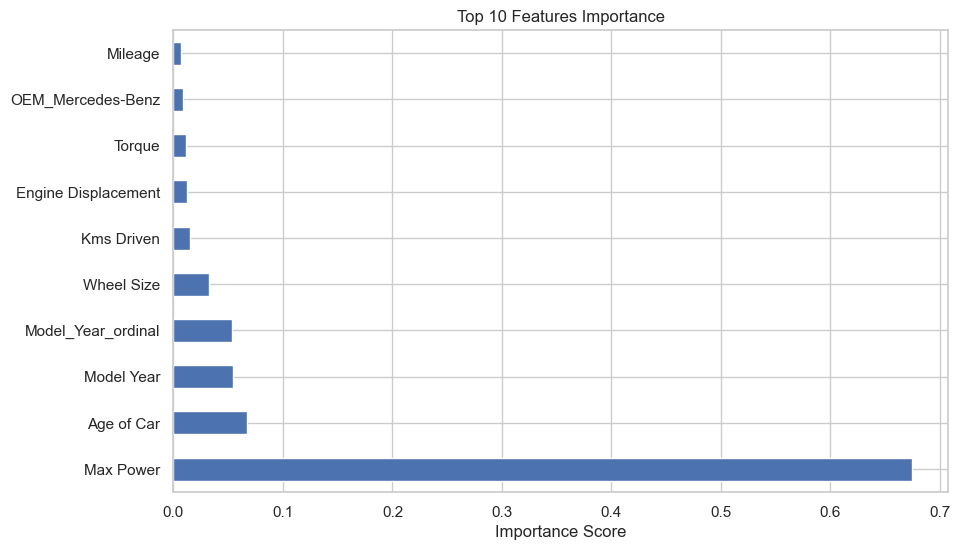

In [21]:
#EDA

# a) Descriptive Statistics
def descriptive_statistics(df):
    print("Descriptive Statistics:")
    print(df.describe(include='all')) 
    print("\nMissing Values:\n", df.isnull().sum()) 

descriptive_statistics(df_cleaned)

# b) Data Visualization

# Set the visualization style
sns.set(style='whitegrid')

# i) Histograms for numerical features
numerical_columns = ['Kms Driven', 'Price',
                     'Mileage', 'Max Power', 'Torque', 'Wheel Size','Owner']

# Apply winsorization to all numerical columns
for col in numerical_columns:
    df_cleaned[col] = mstats.winsorize(df_cleaned[col], limits=[0.05, 0.05])  # 5% lower and upper limits


plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 4, i + 1)
    sns.histplot(df_cleaned[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# ii) Box plots to identify outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=df_cleaned[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# iii) Scatter plots to examine relationships
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    if col != 'Price':  
        plt.subplot(3, 4, i + 1)
        sns.scatterplot(data=df_cleaned, x=col, y='Price')
        plt.title(f'{col} vs Price')
        plt.xlabel(col)
        plt.ylabel('Price')
plt.tight_layout()
plt.show()

# iv) Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df_cleaned[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

# c) Feature Selection

# Prepare features and target variable
X = df_cleaned.drop(columns=['Price'])
y = df_cleaned['Price']

# Fit a Random Forest Regressor to identify feature importance
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Features Importance')
plt.xlabel('Importance Score')
plt.show()


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Separate Features and Target
X = df_cleaned.drop('Price', axis=1)  
y = df_cleaned['Price']  

# 2. Train-Test Split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# 3. Scaling: Apply scaling to all numerical features using StandardScaler
scaler = StandardScaler()

# 4. Define Pipelines for Models (with Scaling for Linear Regression and PCA for Linear Regression)
models = {
    'Decision Tree': Pipeline([('scaler', scaler), ('model', DecisionTreeRegressor(random_state=42))]),
    'Random Forest': Pipeline([('scaler', scaler), ('model', RandomForestRegressor(random_state=42))]),
    'Gradient Boosting': Pipeline([('scaler', scaler), ('model', GradientBoostingRegressor(random_state=42))]),
    'Lasso Regression': Pipeline([('scaler', scaler), ('model', Lasso(alpha=0.1))]),
    'Ridge Regression': Pipeline([('scaler', scaler), ('model', Ridge(alpha=0.1))]),
    'Linear Regression': Pipeline([('scaler', scaler), ('pca', PCA(n_components=0.95, random_state=42)), ('model', LinearRegression())])
}

# 5. Model Training and Cross-Validation
print("\n==== Training Model Performance (Cross-Validation Scores) ====")
for name, pipeline in models.items():
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    print(f"{name}: Mean R2 = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

# 6. Train Final Models and Evaluate on Test Set
results = {}

# Train all models and evaluate performance on the test set
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

# 7. Output Test Set Performance
print("\n==== Test Set Performance ====")
for name, metrics in results.items():
    print(f"{name} -> MAE: {metrics['MAE']:.2f}, MSE: {metrics['MSE']:.2f}, R²: {metrics['R2']:.4f}")

# 8. Hyperparameter Tuning for Random Forest
param_dist = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    models['Random Forest'], 
    param_distributions=param_dist,
    n_iter=10,  # Number of combinations to try
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("\nBest Parameters from Random Search:")
print(random_search.best_params_)

# 9. Evaluate the Best Model on the Test Set

# After hyperparameter tuning
best_model = random_search.best_estimator_

# Get the name of the best model
best_model_name = type(best_model.named_steps['model']).__name__

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)

# Calculate performance metrics
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Print the results including the best model name
print(f"\nBest Model: {best_model_name} -> MAE: {mae_best:.2f}, MSE: {mse_best:.2f}, R²: {r2_best:.4f}")


Training set size: (6542, 380)
Testing set size: (1636, 380)

==== Training Model Performance (Cross-Validation Scores) ====
Decision Tree: Mean R2 = 0.8936, Std = 0.0042
Random Forest: Mean R2 = 0.9409, Std = 0.0059
Gradient Boosting: Mean R2 = 0.9304, Std = 0.0085
Lasso Regression: Mean R2 = 0.9039, Std = 0.0090
Ridge Regression: Mean R2 = 0.9009, Std = 0.0077
Linear Regression: Mean R2 = 0.8789, Std = 0.0111

==== Test Set Performance ====
Decision Tree -> MAE: 100587.73, MSE: 27647601687.27, R²: 0.9130
Random Forest -> MAE: 76515.63, MSE: 15806641069.17, R²: 0.9503
Gradient Boosting -> MAE: 97773.49, MSE: 23064058811.82, R²: 0.9275
Lasso Regression -> MAE: 112789.78, MSE: 30487352045.10, R²: 0.9041
Ridge Regression -> MAE: 112152.23, MSE: 29859228261.78, R²: 0.9061
Linear Regression -> MAE: 130406.95, MSE: 38634712258.51, R²: 0.8785
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters from Random Search:
{'model__n_estimators': 100, 'model__min_samples_spli

In [23]:
import joblib

# Save the best model as a .pkl file
joblib.dump(best_model, 'price_prediction_model_updated.pkl')

['price_prediction_model_updated.pkl']

In [24]:
# Save column names from X_train
joblib.dump(X_train.columns, 'feature_columns.pkl')

['feature_columns.pkl']